# The life of an athlete with type 1 diabetes: descriptives

Descriptives for the 2019 training season of 12 TNN athletes

In [1]:
import numpy as np
import pandas as pd
import datetime
import os
from copy import copy

from plot import *
from calc import glucose_levels_, mmoll_mgdl, mgdl_mmoll, timestamp_to_seconds, perc_in_level
from calc import stats_cgm as stat_func
from config import DATA_PATH, SAVE_PATH

In [2]:
SAVE_PATH = 'results/statistics/'

In [3]:
COL = 'Glucose Value (mg/dL)'

In [4]:
SECTIONS = ('wake', 'exercise', 'recovery', 'sleep')

## Data

### Read data

**Athlete characteristics**

In [5]:
info = pd.read_csv(DATA_PATH+'agg/info.csv')
info = info.reset_index()
info = info.rename(columns={'index':'RIDER'})
info

,RIDER,gender,nationality,age,diabetes_duration,weight,bf(%),HbA1c,FTP,LTHR,HRmax,VO2max,height
0,1,M,Switzerland,22,11,60.500000,9.066667,6.7,307.000000,176.333333,192.333333,68.888889,174.0
1,2,M,Italy,30,14,71.633333,8.833333,6.6,326.000000,168.666667,181.666667,66.915285,178.0
2,3,M,Ireland,26,7,66.733333,6.566667,6.8,298.000000,171.000000,180.000000,66.666164,171.0
3,4,M,Australia,19,7,78.666667,9.433333,7.8,356.000000,170.333333,187.333333,67.333333,178.0
4,5,M,Netherlands,25,6,69.633333,7.700000,6.5,341.000000,179.666667,192.666667,72.857143,183.0
5,6,M,Australia,20,9,56.700000,4.950000,6.4,298.500000,173.000000,184.500000,70.781588,169.0
6,7,M,Italy,22,6,65.333333,8.066667,5.9,298.500000,171.500000,180.500000,72.203125,167.0
7,8,M,New Zealand,20,17,65.000000,11.900000,7.7,292.000000,187.000000,204.000000,64.000000,165.0
8,9,M,France,23,10,63.100000,8.533333,7.2,278.666667,182.333333,195.000000,67.522310,173.0
9,10,M,UK,27,17,75.466667,7.700000,7.3,377.333333,177.000000,194.333333,73.982571,185.0


**Blood tests**

In [6]:
hba1c = pd.read_csv(DATA_PATH+'bloodtests/HbA1c.csv', header=[0,1,2], index_col=[0])
hba1c = hba1c.mean(level=0, axis=1) # calc mean over seasons
hba1c = hba1c.reset_index()
hba1c

,RIDER,2018,2019
0,1,NaN,6.333333
1,2,7.200000,6.533333
2,3,7.100000,6.850000
3,4,NaN,8.000000
4,5,6.800000,6.725000
5,6,NaN,6.550000
6,7,6.825000,6.366667
7,9,7.075000,7.025000
8,10,6.833333,7.233333
9,12,6.025000,5.950000


**Professional**

In [7]:
pro = pd.read_csv(DATA_PATH+'info/pro.csv')
pro = pro.sort_values('RIDER')

Select only people for whom we have *ethics*

In [8]:
pro = pro[pro.ethics == 1]
pro = pro.drop('ethics', axis=1)

# anonymize file
pro = pro.drop('name', axis=1)
pro['RIDER'] = pro['RIDER'].astype(int)
pro = pro.reset_index(drop=True)

pro

,RIDER,2014,2015,2016,2017,2018,2019,2020,2021
0,1,-,-,-,DEV,DEV,PRO,PRO,PRO
1,2,PRO,PRO,PRO,PRO,PRO,PRO,PRO,PRO
2,3,PRO,PRO,PRO,PRO,PRO,PRO,PRO,PRO
3,4,-,-,-,DEV,PRO,PRO,PRO,PRO
4,5,-,PRO,PRO,PRO,PRO,PRO,PRO,PRO
5,6,-,-,-,DEV,DEV,PRO,PRO,PRO
6,7,-,-,DEV,PRO,PRO,PRO,PRO,PRO
7,8,-,-,-,DEV,DEV,DEV,PRO,PRO
8,9,-,-,-,PRO,PRO,PRO,PRO,PRO
9,10,-,-,DEV,DEV,PRO,PRO,PRO,PRO


**Season dates**

In [9]:
season = pd.read_csv(DATA_PATH+'calendar/season_dates.csv', index_col=[0,1], header=[0,1])
season = season.reset_index().drop('level_1', axis=1)
season = season.rename(columns={'level_0':'RIDER'})
season

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


RIDER        2015                    2016                    2017  \
               start         end       start         end       start   
0      1         NaN         NaN         NaN         NaN  2016-12-06   
1      2  2014-11-17  2015-10-18  2015-11-24  2016-10-28  2016-11-15   
2      3  2014-11-06  2015-10-18  2015-11-06  2016-10-23  2016-12-06   
3      4         NaN         NaN         NaN         NaN  2016-11-15   
4      5  2014-11-14  2015-11-08  2015-11-27  2016-10-30  2016-11-12   
5      6         NaN         NaN         NaN         NaN  2016-12-12   
6      7         NaN         NaN  2015-10-07  2016-04-16  2016-11-07   
7      8         NaN         NaN         NaN         NaN  2016-12-14   
8      9         NaN         NaN         NaN         NaN  2016-12-06   
9     10         NaN         NaN  2015-11-06  2016-10-17  2016-11-04   
10    11  2014-11-02  2015-11-12  2015-12-01  2016-11-12  2016-12-07   
11    12  2014-11-15  2015-10-29  2015-11-24  2016-10-22  2016-11-07   
12    13         NaN         NaN         NaN         NaN         NaN   
13    14  2014-11-14  2015-10-25  2015-12-02  2016-10-30  2016-11-13   
14    15  2014-11-17  2015-10-18  2015-11-12  2016-10-23  2016-11-14   
15    16         NaN         NaN         NaN         NaN  2016-12-14   
16    17         NaN         NaN         NaN         NaN         NaN   
17    18         NaN         NaN         NaN         NaN  2016-12-13   

                      2018                    2019                    2020  \
           end       start         end       start         end       start   
0   2017-11-05  2017-11-13  2018-10-20  2018-11-05  2019-10-20  2019-11-04   
1   2017-09-11  2017-10-23  2018-10-02  2018-10-23  2019-10-16  2019-11-04   
2   2017-10-05  2017-11-13  2018-10-31  2018-11-19  2019-10-20  2019-11-13   
3   2017-09-30  2017-10-05  2018-11-01  2018-11-12  2019-10-16  2019-11-04   
4   2017-09-23  2017-10-03  2018-10-17  2018-11-12  2019-10-20  2019-11-11   
5   2017-10-14  2017-10-30  2018-10-25  2018-12-01  2019-10-01  2019-10-21   
6   2017-11-05  2017-11-28  2018-10-17  2018-11-29  2019-10-27  2019-12-02   
7   2017-11-05  2017-11-19  2018-12-12  2018-12-24  2019-10-16  2019-10-24   
8   2017-11-05  2017-11-20  2018-09-24  2018-11-05  2019-09-23  2019-10-14   
9   2017-11-12  2017-11-27  2018-11-10  2018-11-22  2019-10-28  2019-11-11   
10  2017-10-22         NaN         NaN  2018-10-15  2019-06-23  2019-10-23   
11  2017-10-31  2017-11-06  2018-11-11  2018-11-26  2019-11-05  2019-11-18   
12         NaN         NaN         NaN  2018-12-12  2019-10-20  2019-11-18   
13  2017-11-20  2017-12-21  2018-11-01  2018-11-12  2019-09-09  2019-10-21   
14  2017-11-01  2017-11-27  2018-10-21  2018-11-12  2019-10-20  2019-11-09   
15  2017-09-10  2017-11-21  2018-11-02  2018-11-19  2019-09-29  2019-11-14   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17  2017-10-22  2017-11-20  2018-08-12  2018-10-22  2019-10-13  2019-11-09   

                      2021              
           end       start         end  
0   2020-09-23  2020-10-08  2021-10-30  
1   2020-10-11  2020-11-09  2021-10-04  
2   2020-10-16  2020-11-16  2021-10-03  
3   2020-10-28  2020-11-16  2021-08-14  
4   2020-10-31  2020-11-16  2021-08-31  
5   2020-07-17  2020-11-01  2021-09-03  
6   2020-10-12  2020-11-09  2021-09-30  
7   2020-09-27  2020-11-01  2021-10-03  
8   2020-10-12  2020-11-05  2021-10-01  
9   2020-10-11  2020-11-16  2021-10-17  
10  2020-10-02  2020-11-01  2021-09-17  
11  2020-10-08  2020-11-01  2021-09-03  
12  2020-10-11  2020-11-16  2021-09-05  
13  2020-10-12  2020-11-02  2021-09-20  
14  2020-10-15  2020-11-07  2021-10-29  
15  2020-10-31  2020-11-23  2021-09-30  
16         NaN         NaN         NaN  
17  2020-10-18  2020-11-11  2021-10-05

**TrainingPeaks (aggregated)**

In [10]:
tp_agg = pd.read_csv(DATA_PATH+'agg/trainingpeaks_day.csv', index_col=[0,1], header=[0,1])
tp_agg = tp_agg.reset_index()
tp_agg['date'] = pd.to_datetime(tp_agg['date'])
tp_agg

RIDER       date            TIME                       \
                       timestamp_count  local_timestamp_min   
0         1 2016-11-22          7446.0  2016-11-22 12:58:57   
1         1 2016-11-23          7312.0  2016-11-23 14:29:13   
2         1 2016-11-24          6285.0  2016-11-24 09:53:38   
3         1 2016-11-26          7445.0  2016-11-26 10:00:35   
4         1 2016-12-06         11222.0  2016-12-06 09:11:34   
...     ...        ...             ...                  ...   
30207    18 2021-11-18          4767.0  2021-11-18 14:58:17   
30208    18 2021-11-25         10912.0  2021-11-25 09:50:57   
30209    18 2021-11-26          8737.0  2021-11-26 10:12:34   
30210    18 2021-11-27         18222.0  2021-11-27 09:31:58   
30211    18 2021-11-28         14549.0  2021-11-28 10:02:22   

                                                CALENDAR                      \
       local_timestamp_max file_id_unique_count     race travel race_3d_mean   
0      2016-11-22 15:15:40                  1.0    False   True          0.0   
1      2016-11-23 16:35:14                  1.0    False  False          0.0   
2      2016-11-24 16:56:38                  2.0    False  False          0.0   
3      2016-11-26 12:12:52                  1.0    False  False          0.0   
4      2016-12-06 16:11:38                  2.0    False  False          0.0   
...                    ...                  ...      ...    ...          ...   
30207  2021-11-18 16:19:15                  1.0    False  False          0.0   
30208  2021-11-25 12:54:14                  1.0    False  False          0.0   
30209  2021-11-26 12:39:08                  1.0    False  False          0.0   
30210  2021-11-27 14:36:43                  1.0    False  False          0.0   
30211  2021-11-28 14:21:57                  1.0    False  False          0.0   

                    ...                LOC                     \
      race_7d_mean  ... vertical_speed_min vertical_speed_max   
0              0.0  ...                NaN                NaN   
1              0.0  ...                NaN                NaN   
2              0.0  ...                NaN                NaN   
3              0.0  ...                NaN                NaN   
4              0.0  ...                NaN                NaN   
...            ...  ...                ...                ...   
30207          0.0  ...                NaN                NaN   
30208          0.0  ...                NaN                NaN   
30209          0.0  ...                NaN                NaN   
30210          0.0  ...                NaN                NaN   
30211          0.0  ...                NaN                NaN   

                                                                     \
      vertical_speed_sum vertical_speed_energy vertical_speed_peaks   
0                    NaN                   NaN                  NaN   
1                    NaN                   NaN                  NaN   
2                    NaN                   NaN                  NaN   
3                    NaN                   NaN                  NaN   
4                    NaN                   NaN                  NaN   
...                  ...                   ...                  ...   
30207                NaN                   NaN                  NaN   
30208                NaN                   NaN                  NaN   
30209                NaN                   NaN                  NaN   
30210                NaN                   NaN                  NaN   
30211                NaN                   NaN                  NaN   

                                                                              \
      vertical_speed_rms distance_up_iqr vertical_speed_iqr acceleration_iqr   
0                    NaN             NaN                NaN              NaN   
1                    NaN             NaN                NaN              NaN   
2                    NaN             NaN               

**Dexcom (aggregated)**

In [11]:
dc_agg = pd.read_csv(DATA_PATH+'agg/dexcom_day.csv')

dc_agg['date'] = pd.to_datetime(dc_agg['date'])

dc_agg = dc_agg.dropna(subset=['glucose_mean_'+i for i in ('exercise', 'recovery', 'sleep', 'wake')], how='all')
dc_agg = dc_agg.reset_index(drop=True)
dc_agg

/local/home/evanweenen/.local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3258: DtypeWarning: Columns (51,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,RIDER,date,time_in_hypo_day,time_in_hypoL2_day,time_in_hypoL1_day,time_in_target_day,time_in_hyper_day,time_in_hyperL1_day,time_in_hyperL2_day,perc_in_hypo_day,...,count_sleep,LBGI_sleep,HBGI_sleep,AUC_sleep,hypo_sleep,hyper_sleep,race_day,travel_day,exercise_day,completeness
0,1,2017-09-12,0,0,0,130,30,30,0,0.000000,...,72.0,0.000000,2.233929,10130.5,False,False,False,False,True,0.555556
1,1,2017-09-13,0,0,0,203,85,68,17,0.000000,...,72.0,1.006374,0.007478,6910.0,False,False,False,False,True,1.000000
2,1,2017-09-14,7,0,7,247,46,46,0,2.333333,...,72.0,1.302753,0.001658,6824.5,False,False,False,False,True,1.000000
3,1,2017-09-15,17,0,17,254,17,17,0,5.902778,...,72.0,0.000000,1.007591,9408.5,False,False,False,True,True,1.000000
4,1,2017-09-16,10,1,9,189,22,22,0,4.524887,...,72.0,1.190592,0.000083,6808.0,False,False,False,False,True,0.767361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11803,9,2020-02-11,0,0,0,149,111,106,5,0.000000,...,72.0,0.462046,6.585822,11036.7,False,True,False,False,False,0.902778
11804,9,2020-02-12,1,0,1,199,33,25,8,0.429185,...,72.0,0.009297,1.769761,9824.4,False,False,False,False,True,0.809028
11805,9,2020-02-13,1,0,1,117,8,8,0,0.793651,...,0.0,0.000000,0.000000,NaN,False,False,False,False,True,0.437500
11806,9,2020-07-23,0,0,0,0,1,1,0,0.000000,...,0.0,0.000000,0.000000,NaN,False,False,False,False,True,0.003623


**Dexcom (full)**

In [12]:
dc = pd.read_csv(DATA_PATH+'agg/dexcom.csv')

dc['timestamp'] = pd.to_datetime(dc['timestamp'])
dc['local_timestamp'] = pd.to_datetime(dc['local_timestamp'])

dc['date'] = pd.to_datetime(dc['date'])
dc

,RIDER,timestamp,Glucose Value (mg/dL),local_timestamp,exercise,recovery,wake,sleep,date,race_day,travel_day,exercise_day,hypo,hyper,glucose_rate,completeness
0,1,2014-01-01 00:00:00,NaN,2013-12-31 20:00:00,False,False,True,False,2013-12-31,False,False,False,False,False,NaN,0.0
1,1,2014-01-01 00:05:00,NaN,2013-12-31 20:05:00,False,False,True,False,2013-12-31,False,False,False,False,False,NaN,0.0
2,1,2014-01-01 00:10:00,NaN,2013-12-31 20:10:00,False,False,True,False,2013-12-31,False,False,False,False,False,NaN,0.0
3,1,2014-01-01 00:15:00,NaN,2013-12-31 20:15:00,False,False,True,False,2013-12-31,False,False,False,False,False,NaN,0.0
4,1,2014-01-01 00:20:00,NaN,2013-12-31 20:20:00,False,False,True,False,2013-12-31,False,False,False,False,False,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15147643,18,2021-12-31 23:35:00,NaN,2022-01-01 00:35:00,False,False,False,True,2021-12-31,False,False,False,False,False,NaN,0.0
15147644,18,2021-12-31 23:40:00,NaN,2022-01-01 00:40:00,False,False,False,True,2021-12-31,False,False,False,False,False,NaN,0.0
15147645,18,2021-12-31 23:45:00,NaN,2022-01-01 00:45:00,False,False,False,True,2021-12-31,False,False,False,False,False,NaN,0.0
15147646,18,2021-12-31 23:50:00,NaN,2022-01-01 00:50:00,False,False,False,True,2021-12-31,False,False,False,False,False,NaN,0.0


### Select data

#### Select athletes that were pro in 2019

In [13]:
ATHLETES = pro.loc[pro['2019'] == 'PRO', 'RIDER'].to_list()

In [14]:
info = info[info.RIDER.isin(ATHLETES)].set_index('RIDER')
season = season[season.RIDER.isin(ATHLETES)].set_index('RIDER')
hba1c = hba1c[hba1c.RIDER.isin(ATHLETES)].set_index('RIDER')

In [15]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(tp_agg[tp_agg.RIDER.isin(ATHLETES)]))
print("Dexcom (agg): N =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc_agg[dc_agg.RIDER.isin(ATHLETES)]))
print("Dexcom: N =", len(dc[dc.RIDER.isin(ATHLETES)].RIDER.unique()), 
      "; D =", len(dc[dc.RIDER.isin(ATHLETES)].dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 25116
Dexcom (agg): N = 14 ; D = 9246
Dexcom: N = 14 ; D = 9246


#### Select beginning and end of the training season in 2019

In [16]:
hba1c = hba1c['2019']
hba1c.name = 'HbA1c'

In [17]:
# merge 
info = info.drop('HbA1c', axis=1)
info = pd.merge(info, hba1c, left_index=True, right_index=True, how='left')

In [18]:
season = season['2019']

season['start'] = pd.to_datetime(season['start'])
season['end'] = pd.to_datetime(season['end'])

season_list = season.apply(lambda x: pd.date_range(x[0], x[1], freq='1D'), axis=1)\
    .apply(pd.Series).stack().reset_index().drop('level_1', axis=1).rename(columns={0:'date'})
season_list

,RIDER,date
0,1,2018-11-05
1,1,2018-11-06
2,1,2018-11-07
3,1,2018-11-08
4,1,2018-11-09
...,...,...
4642,16,2019-09-25
4643,16,2019-09-26
4644,16,2019-09-27
4645,16,2019-09-28


In [19]:
tp_agg = pd.merge(tp_agg, season_list, how='inner', on=['RIDER', 'date'])
dc_agg = pd.merge(dc_agg, season_list, how='inner', on=['RIDER', 'date'])
dc = pd.merge(dc, season_list, how='inner', on=['RIDER', 'date'])

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


In [20]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc.dropna(subset=['Glucose Value (mg/dL)'])[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 3071
Dexcom: N = 14 ; D = 3071


#### Select days with glucose completeness >= 70%

In [21]:
dc.loc[dc['completeness'] < 0.7, 'Glucose Value (mg/dL)'] = np.nan
dc = dc.dropna(subset=['Glucose Value (mg/dL)'])

In [22]:
dc_agg = dc_agg[dc_agg['completeness_day'] >= 0.7]

In [23]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 14 ; D = 3828
Dexcom (agg): N = 14 ; D = 2133
Dexcom: N = 14 ; D = 2133


#### Select participants with 14 or more days of data

In [24]:
mask = dc_agg.groupby('RIDER')['date'].nunique() >= 14
ATHLETES = mask[mask].index

info = info.loc[ATHLETES]
season_list = season_list[season_list.RIDER.isin(ATHLETES)]

tp_agg = tp_agg[tp_agg.RIDER.isin(ATHLETES)]
dc_agg = dc_agg[dc_agg.RIDER.isin(ATHLETES)]
dc = dc[dc.RIDER.isin(ATHLETES)]

In [25]:
print("Data available: ")
print("TrainingPeaks (agg): N =", len(tp_agg.RIDER.unique()), "; D =", len(tp_agg))
print("Dexcom (agg): N =", len(dc_agg.RIDER.unique()), "; D =", len(dc_agg))
print("Dexcom: N =", len(dc.RIDER.unique()), "; D =", len(dc[['RIDER', 'date']].drop_duplicates()))

Data available: 
TrainingPeaks (agg): N = 12 ; D = 3370
Dexcom (agg): N = 12 ; D = 2115
Dexcom: N = 12 ; D = 2115


In [26]:
print("Race days: ", 
      len(dc.loc[dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Race days with CGM during exercise: ", 
      len(dc.loc[dc['exercise_day'] & dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Training days: ", 
      len(dc.loc[dc['exercise_day'] & ~dc['race_day'], ['RIDER', 'date']].drop_duplicates()))
print("Exercise days: ", 
      len(dc.loc[dc['exercise_day'], ['RIDER', 'date']].drop_duplicates()))

Race days:  261
Race days with CGM during exercise:  256
Training days:  1536
Exercise days:  1792


In [27]:
season_length = season_list.groupby('RIDER').count()
print("Season length: {:.1f} [{:.1f}-{:.1f}]".format(season_length.median().item(), 
                                                     season_length.quantile(0.25).item(),
                                                     season_length.quantile(0.75).item()))

Season length: 340.0 [314.5-343.5]


**Give participants a new ID (so that it is not confusing for the paper)**

In [28]:
map_id = {i: n+1 for n, i in enumerate(dc.groupby('RIDER').apply(stat_func).apply(pd.Series)['perc_in_target_'].sort_values(ascending=False).index)}
map_id

{13: 1,
 6: 2,
 5: 3,
 12: 4,
 15: 5,
 3: 6,
 2: 7,
 1: 8,
 16: 9,
 14: 10,
 4: 11,
 10: 12}

In [29]:
ATHLETES = sorted([*map(map_id.get, ATHLETES)])

info.index = info.index.map(map_id)
info = info.sort_index()

season.index = season.index.map(map_id)
season = season.sort_index()

season_list.RIDER = season_list.RIDER.map(map_id)

tp_agg.RIDER = tp_agg.RIDER.map(map_id)
dc_agg.RIDER = dc_agg.RIDER.map(map_id)
dc.RIDER = dc.RIDER.map(map_id)

rider_mapping_inv = {map_id[k]:v for k,v in rider_mapping_inv.items() if k in map_id.keys()}

/local/home/evanweenen/.local/lib/python3.7/site-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Summary statistics

### Participant characteristics

In [30]:
info['bmi'] = info['weight'] / (info['height']/100)**2

In [31]:
# ------ info
cols_info = {'age'    : 'Age [yr]',
             'gender' : 'Sex [male/female]',
             'height' : 'Height [cm]',
             'weight' : 'Weight [kg]',
             'bf(%)'  : 'Fat mass [\%]'}

info['FTP_per_kg'] = info['FTP'] / info['weight']
info = info.drop('FTP', axis=1)

stats_info = info.loc[:,info.columns.isin(cols_info.keys())]
stats_info = stats_info.rename(columns=cols_info)

In [32]:
# ------ diabetes
cols_diab = {'diabetes_duration' : 'Diabetes duration [yr]',
             'HbA1c'             : 'HbA_{1c} [\%]',
             'cgm_days'          : 'Days with CGM coverage $\geq$ 70 \%'}

stats_diab = info.loc[:, info.columns.isin(cols_diab.keys())]
stats_diab['cgm_days'] = dc_agg.reset_index().groupby('RIDER')['date'].count()
stats_diab = stats_diab.rename(columns=cols_diab)

/local/home/evanweenen/.local/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [33]:
# ------ exercise
cols_ex = {'FTP_per_kg'                : 'Functional threshold power (FTP) [W/kg]',
           'LTHR'                      : 'Lactate threshold heart rate (LTHR) [bpm]',
           'HRmax'                     : 'Maximum heart rate (HR_{max}) [bpm]',
           'VO2max'                    : 'Maximum rate of oxygen consumption (VO_{2max}) [mL/min/kg]',
           'days_per_year_cycled'      : 'Cycling [days/yr]',
           'days_per_year_raced'       : 'Competition [days/yr]',
           'km_per_year_cycled'        : 'Distance cycled [km/yr]',
           'mean_hours_per_day_cycled' : 'Mean time cycled [h/day]',
           'mean_km_per_day_cycled'    : 'Mean distance cycled [km/day]',
           'mean_m_per_day_ascended'   : 'Mean ascension [m/day]'}

tp_agg0 = tp_agg.set_index(['RIDER', 'date'])
tp_agg0.columns = tp_agg0.columns.get_level_values(1)
tp_agg0 = tp_agg0.reset_index()

stats_ex_yr = tp_agg0.groupby('RIDER').agg({'date'        :'count', 
                                            'race'        :'sum', 
                                            'distance_max':lambda x: x.sum()/1000})\
                           .rename(columns={'date'        :'days_per_year_cycled',
                                            'race'        :'days_per_year_raced',
                                            'distance_max':'km_per_year_cycled'})

stats_ex_day = tp_agg0.groupby('RIDER').agg({'timestamp_count'      :lambda x: x.mean()/3600,
                                             'distance_max'         :lambda x: x.mean()/1000,
                                             'elevation_gain_up_sum':'mean'})\
    .rename(columns={'timestamp_count'      :'mean_hours_per_day_cycled',
                     'distance_max'         :'mean_km_per_day_cycled',
                     'elevation_gain_up_sum':'mean_m_per_day_ascended'})

stats_ex = info[sorted(set(cols_ex.keys()) & set(info.columns))]
stats_ex = pd.merge(stats_ex, stats_ex_yr, left_index=True, right_index=True, how='outer')
stats_ex = pd.merge(stats_ex, stats_ex_day, left_index=True, right_index=True, how='outer')
stats_ex = stats_ex.rename(columns=cols_ex)

In [34]:
stats = pd.concat([stats_info, stats_diab, stats_ex], axis=1)
stats

,Sex [male/female],Age [yr],Weight [kg],Fat mass [\%],Height [cm],Diabetes duration [yr],HbA_{1c} [\%],Days with CGM coverage $\geq$ 70 \%,Functional threshold power (FTP) [W/kg],Maximum heart rate (HR_{max}) [bpm],Lactate threshold heart rate (LTHR) [bpm],Maximum rate of oxygen consumption (VO_{2max}) [mL/min/kg],Cycling [days/yr],Competition [days/yr],Distance cycled [km/yr],Mean time cycled [h/day],Mean distance cycled [km/day],Mean ascension [m/day]
RIDER,,,,,,,,,,,,,,,,,,
1,M,34,60.333333,4.866667,179.0,1,6.366667,277,5.729282,182.333333,173.000000,76.666667,233,46,21068.77414,2.923549,97.091125,1182.303390
2,M,20,56.700000,4.950000,169.0,9,6.550000,206,5.264550,184.500000,173.000000,70.781588,254,4,20826.51886,2.931333,86.059995,1092.717246
3,M,25,69.633333,7.700000,183.0,6,6.725000,302,4.897080,192.666667,179.666667,72.857143,272,23,25053.89436,3.148100,97.108118,973.424480
4,M,30,64.000000,5.600000,178.0,8,5.950000,98,5.421875,178.666667,158.333333,75.937500,322,51,35900.00814,3.718611,113.249237,1805.023310
5,M,25,73.766667,7.200000,179.0,15,6.525000,94,5.273385,198.000000,185.000000,66.000000,290,54,28970.01517,3.242701,102.367545,1332.903563
6,M,26,66.733333,6.566667,171.0,7,6.850000,144,4.465534,180.000000,171.000000,66.666164,293,20,23242.18201,3.056150,81.551516,1258.335836
7,M,30,71.633333,8.833333,178.0,14,6.533333,178,4.550954,181.666667,168.666667,66.915285,310,52,31697.65813,3.278969,112.005859,1133.426596
8,M,22,60.500000,9.066667,174.0,11,6.333333,323,5.074380,192.333333,176.333333,68.888889,287,30,25031.37962,3.055672,90.365991,1312.419861
9,M,22,56.666667,9.466667,170.0,13,6.825000,46,5.000000,200.333333,125.610000,74.678571,249,23,20091.80264,2.806168,82.682315,861.395984


Calculate mean and std over all riders and write to latex

In [35]:
def agg_gender(x):
    count = x.value_counts()
    male = count['M'] if 'M' in count else 0
    female = count['F'] if 'F' in count else 0
    return f'{male}/{female}'

In [36]:
stats_agg = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1).round(1)
stats_agg = pd.concat([pd.Series(stats['Sex [male/female]'].agg(agg_gender), index=['Sex [male/female]']),
                       stats_agg])

stats_agg = stats_agg.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
stats_agg.apply(lambda x: pd.Series([x['median'], f"[{x['p25']}--{x['p75']}]"]), axis=1).to_csv(SAVE_PATH+"stats_characteristics.csv")
stats_agg

,median,p25,p75
Sex [male/female],12/0,NaN,NaN
Age [yr],25.5,22.0,27.8
Weight [kg],68.2,60.5,74.1
Fat mass [\%],7.7,6.3,9.1
Height [cm],178.0,173.2,180.0
Diabetes duration [yr],10.0,7.0,14.2
HbA_{1c} [\%],6.6,6.5,6.9
Days with CGM coverage $\geq$ 70 \%,161.0,109.2,223.8
Functional threshold power (FTP) [W/kg],5.0,4.6,5.3
Maximum heart rate (HR_{max}) [bpm],188.4,182.2,193.1


In [37]:
stats_agg = stats_agg.apply(lambda x: f"{x['median']} & [{x['p25']} & {x['p75']}]", axis=1)

with open(SAVE_PATH+"stats_characteristics.tex", 'w') as file:
	file.write(stats_agg.to_latex(column_format='c', escape=False))

### Continuous Glucose Monitoring

In [38]:
cols_cgm = {'glucose_mean'    : 'Mean glucose [mg/dL]',
            'glucose_cv'      : 'Glycemic variability [\%]',
            'perc_in_hypo'    : 'hypoglycemia (<70 mg/dL)',
            'perc_in_hypoL2'  : 'hypoglycemia L2 (<54 mg/dL)',
            'perc_in_hypoL1'  : 'hypoglycemia L1 (54-69 mg/dL)',
            'perc_in_target'  : 'target range (70-180 mg/dL)',
            'perc_in_hyper'   : 'hyperglycemia (>180 mg/dL)',
            'perc_in_hyperL1' : 'hyperglycemia L1 (181-250 mg/dL)',
            'perc_in_hyperL2' : 'hyperglycemia L2 (>250 mg/dL)'}

In [39]:
stat_cols = ['day'] + list(SECTIONS)

In [40]:
dc['day'] = True

In [41]:
days = {'all'   : dc,
        'train' : dc[dc['exercise_day'] & ~dc['race_day']],
        'race'  : dc[dc['exercise_day'] & dc['race_day']]}

In [42]:
tnames = {'all'  : r"All days (d={:.0f})".format(len(days['all'][['RIDER', 'date']].drop_duplicates())),
          'train': r"Training days (d={:.0f})".format(len(days['train'][['RIDER', 'date']].drop_duplicates())),
          'race' : r"Competition days (d={:.0f})".format(len(days['race'][['RIDER', 'date']].drop_duplicates()))}

In [43]:
def get_cgm_stats(df, combine=False):
    stats = {}
    for sec in stat_cols:
        s = df[df[sec]].groupby('RIDER').apply(stat_func, sec=sec).apply(pd.Series)
        if combine == True:
            cols = {f'{c}_{sec}':c for c in cols_cgm.keys() if not c.endswith('L1') and not c.endswith('L2')}
        elif combine == False:
            cols = {f'{c}_{sec}':c for c in cols_cgm.keys() if c != 'perc_in_hypo' and c != 'perc_in_hyper'}
        elif combine == 'all':
            cols = {f'{c}_{sec}':c for c in cols_cgm.keys()}
        stats[sec] = s[cols.keys()].rename(columns=cols)
    stats = pd.concat(stats, axis=1)
    return stats

In [44]:
def agg_cgm(df, combine=False):
    stats = get_cgm_stats(df, combine)
    
    stats = pd.concat([stats.median(), stats.quantile(0.25), stats.quantile(0.75)], axis=1)
    stats = stats.rename(columns={0.00:'median', 0.25:'p25', 0.75:'p75'})
    stats = stats.round(1)

    # get it to the right format
    stats = stats.unstack(level=0)
    stats.columns = stats.columns.swaplevel(0,1)

    stats = stats.rename(index=cols_cgm)
    stats = stats[stat_cols]
    return stats

In [45]:
def highlight_cell(stats, col, func):
    stats.loc[col, pd.IndexSlice[:,'median']] = stats.loc[col,pd.IndexSlice[:,'median']].applymap(func)
    return stats

In [46]:
stats_cgm = {name: agg_cgm(df) for name, df in days.items()}

stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm

day                 wake                \
                                 median    p25    p75 median    p25    p75   
All days (d=2115)                   NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              145.3  135.3  157.0  150.4  138.3  160.7   
Glycemic variability [\%]          39.9   34.0   41.7   38.9   33.3   40.9   
hypoglycemia L2 (<54 mg/dL)         1.3    0.4    2.9    0.8    0.3    1.9   
hypoglycemia L1 (54-69 mg/dL)       4.2    2.2    6.4    3.5    1.9    5.2   
target range (70-180 mg/dL)        66.1   62.4   82.2   66.6   59.2   81.9   
hyperglycemia L1 (181-250 mg/dL)   17.9   12.6   22.2   18.7   13.4   23.7   
hyperglycemia L2 (>250 mg/dL)       7.0    1.5    9.9    6.9    1.5   10.1   
Training days (d=1536)              NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              141.8  135.6  151.1  146.6  138.2  151.9   
Glycemic variability [\%]          40.6   33.4   42.3   39.2   32.8   41.0   
hypoglycemia L2 (<54 mg/dL)         1.5    0.4    2.7    0.8    0.3    1.7   
hypoglycemia L1 (54-69 mg/dL)       4.8    2.2    6.8    4.3    2.0    5.1   
target range (70-180 mg/dL)        67.4   64.6   82.4   68.5   63.2   82.6   
hyperglycemia L1 (181-250 mg/dL)   16.9   11.6   21.2   18.4   12.3   22.6   
hyperglycemia L2 (>250 mg/dL)       5.7    1.4    8.7    6.1    1.5    8.6   
Competition days (d=256)            NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]              143.6  139.4  160.3  153.3  142.7  166.1   
Glycemic variability [\%]          37.5   29.4   39.8   36.9   30.2   38.0   
hypoglycemia L2 (<54 mg/dL)         0.6    0.3    1.7    0.5    0.3    1.4   
hypoglycemia L1 (54-69 mg/dL)       2.4    1.4    4.1    2.2    0.9    3.9   
target range (70-180 mg/dL)        64.1   60.3   84.7   68.8   58.2   81.5   
hyperglycemia L1 (181-250 mg/dL)   18.2   12.9   24.4   18.8   15.3   25.0   
hyperglycemia L2 (>250 mg/dL)       6.9    1.2   12.1    6.0    1.7   12.0   

                                 exercise               recovery         \
                                   median    p25    p75   median    p25   
All days (d=2115)                     NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                143.6  130.4  163.0    157.3  141.8   
Glycemic variability [\%]            36.9   34.9   44.3     35.5   32.7   
hypoglycemia L2 (<54 mg/dL)           0.5    0.2    1.1      0.5    0.2   
hypoglycemia L1 (54-69 mg/dL)         3.4    2.0    4.9      2.3    1.4   
target range (70-180 mg/dL)          71.0   58.7   83.0     67.2   59.1   
hyperglycemia L1 (181-250 mg/dL)     14.5    9.4   26.8     21.9   16.1   
hyperglycemia L2 (>250 mg/dL)         8.0    1.3   10.7      6.5    3.4   
Training days (d=1536)                NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                137.5  125.6  151.4    154.6  142.9   
Glycemic variability [\%]            37.5   35.0   44.3     35.6   32.8   
hypoglycemia L2 (<54 mg/dL)           0.6    0.2    1.1      0.4    0.2   
hypoglycemia L1 (54-69 mg/dL)         3.4    2.2    6.3      2.3    1.4   
target range (70-180 mg/dL)          74.0   61.8   83.5     68.5   59.5   
hyperglycemia L1 (181-250 mg/dL)     14.1    8.5   22.7     22.2   16.4   
hyperglycemia L2 (>250 mg/dL)         6.7    0.9    8.7      6.1    3.5   
Competition days (d=256)              NaN    NaN    NaN      NaN    NaN   
Mean glucose [mg/dL]                170.6  160.3  178.0    164.3  144.4   
Glycemic variability [\%]            30.0   29.1   38.0     32.8   28.7   
hypoglycemia L2 (<54 mg/dL)           0.0    0.0    0.2      0.3    0.0   
hypoglycemia L1 (54-69 mg/dL)         0.5    0.1    1.5      1.6    0.8   
target range (70-180 mg/dL)          58.6   56.4   68.9     64.9   58.2   
hyperglycemia L1 (181-250 mg/dL)     23.7   20.4   31.5     20.8   15.3   
hyperglycemia L2 (>250 mg/dL)        12.8    7.0   18.2      7.7    2.1   

                                         sleep          

In [47]:
stats_cgm_csv = stats_cgm.T.groupby(level=0).apply(lambda x: x.T.apply(lambda x: pd.Series([x[pd.IndexSlice[:, 'median']].values[0], f"[{x[pd.IndexSlice[:, 'p25']].values[0]}--{x[pd.IndexSlice[:, 'p75']].values[0]}]"]), axis=1)).unstack(level=0)
stats_cgm_csv.columns = stats_cgm_csv.columns.swaplevel(0,1)
stats_cgm_csv = stats_cgm_csv.reindex(pd.MultiIndex.from_product([stat_cols, [0,1]]), axis=1)
stats_cgm_csv.to_csv(SAVE_PATH+"stats_cgm.csv")

In [48]:
#stats_cgm = highlight_cell(stats_cgm, 'Mean glucose (mg/dL)', lambda x: pd.DataFrame(False, index=x.index, columns=x.columns))
stats_cgm = highlight_cell(stats_cgm, 'Glycemic variability [\%]', lambda x: '\hl'+str(x) if x > 36 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L2 (<54 mg/dL)', lambda x: '\hl'+str(x) if x > 1 else x)
stats_cgm = highlight_cell(stats_cgm, 'hypoglycemia L1 (54-69 mg/dL)', lambda x: '\hl'+str(x) if x > 3 else x)
stats_cgm = highlight_cell(stats_cgm, 'target range (70-180 mg/dL)', lambda x: '\hl'+str(x) if x < 70 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L1 (181-250 mg/dL)', lambda x: '\hl'+str(x) if x > 20 else x)
stats_cgm = highlight_cell(stats_cgm, 'hyperglycemia L2 (>250 mg/dL)', lambda x: '\hl'+str(x) if x > 5 else x)

In [49]:
stats_cgm.index = pd.MultiIndex.from_arrays([8*['all']+8*['comp']+8*['train'], stats_cgm.index])
stats_cgm.columns = stats_cgm.columns.swaplevel(0,1)
stats_cgm = stats_cgm.stack(dropna=False)
#stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} ({x['p25']} - {x['p75']})", axis=1)
stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} & \hl[{x['p25']}--{x['p75']}]" if str(x['median']).startswith('\hl') else (f"{x['median']} & [{x['p25']}--{x['p75']}]" if x.isna().sum() != 3 else np.nan), axis=1)
stats_cgm = stats_cgm.unstack()
stats_cgm = stats_cgm.sort_index(key=lambda x: x.map({**{k:i for i, k in enumerate(tnames.keys())}, **{k:0 for k in tnames.values()}, **{k:i+1 for i, k in enumerate(cols_cgm.values())}}))
stats_cgm = stats_cgm[stat_cols]
stats_cgm = stats_cgm.rename(index={k: '\hspace{7mm}'+k for k in list(cols_cgm.values())[2:]})
stats_cgm = stats_cgm.reset_index().drop('level_0', axis=1).set_index('level_1')
with open(SAVE_PATH+"stats_cgm.tex", 'w') as file:
	file.write(stats_cgm.to_latex(column_format='lrrrrr', escape=False))

Combine L1 and L2

In [50]:
stats_cgm = {name: agg_cgm(df, combine=True) for name, df in days.items()}

stats_cgm0 = pd.DataFrame(columns=stats_cgm['all'].columns)
for name, stats in stats_cgm.items():
    row = pd.DataFrame(np.nan, index=[tnames[name]], columns=stats_cgm['all'].columns)
    stats_cgm0 = pd.concat([stats_cgm0, row, stats])
stats_cgm = stats_cgm0
stats_cgm

day                 wake                \
                            median    p25    p75 median    p25    p75   
All days (d=2115)              NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         145.3  135.3  157.0  150.4  138.3  160.7   
Glycemic variability [\%]     39.9   34.0   41.7   38.9   33.3   40.9   
hypoglycemia (<70 mg/dL)       5.3    2.6    9.2    4.6    2.3    7.2   
target range (70-180 mg/dL)   66.1   62.4   82.2   66.6   59.2   81.9   
hyperglycemia (>180 mg/dL)    25.3   14.1   33.8   27.3   14.9   35.8   
Training days (d=1536)         NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         141.8  135.6  151.1  146.6  138.2  151.9   
Glycemic variability [\%]     40.6   33.4   42.3   39.2   32.8   41.0   
hypoglycemia (<70 mg/dL)       6.1    2.6    9.7    5.2    2.3    6.8   
target range (70-180 mg/dL)   67.4   64.6   82.4   68.5   63.2   82.6   
hyperglycemia (>180 mg/dL)    23.1   13.0   30.7   25.1   13.8   31.7   
Competition days (d=256)       NaN    NaN    NaN    NaN    NaN    NaN   
Mean glucose [mg/dL]         143.6  139.4  160.3  153.3  142.7  166.1   
Glycemic variability [\%]     37.5   29.4   39.8   36.9   30.2   38.0   
hypoglycemia (<70 mg/dL)       2.5    2.0    5.8    3.0    1.3    5.0   
target range (70-180 mg/dL)   64.1   60.3   84.7   68.8   58.2   81.5   
hyperglycemia (>180 mg/dL)    24.7   13.9   33.6   28.0   17.2   37.2   

                            exercise               recovery                \
                              median    p25    p75   median    p25    p75   
All days (d=2115)                NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           143.6  130.4  163.0    157.3  141.8  165.1   
Glycemic variability [\%]       36.9   34.9   44.3     35.5   32.7   41.9   
hypoglycemia (<70 mg/dL)         4.0    2.2    6.0      2.7    1.6    6.1   
target range (70-180 mg/dL)     71.0   58.7   83.0     67.2   59.1   72.6   
hyperglycemia (>180 mg/dL)      23.2   10.3   35.9     29.9   21.6   34.4   
Training days (d=1536)           NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           137.5  125.6  151.4    154.6  142.9  159.8   
Glycemic variability [\%]       37.5   35.0   44.3     35.6   32.8   40.8   
hypoglycemia (<70 mg/dL)         4.1    2.4    8.1      2.8    1.6    5.6   
target range (70-180 mg/dL)     74.0   61.8   83.5     68.5   59.5   72.6   
hyperglycemia (>180 mg/dL)      20.8    9.3   30.5     28.8   21.9   32.9   
Competition days (d=256)         NaN    NaN    NaN      NaN    NaN    NaN   
Mean glucose [mg/dL]           170.6  160.3  178.0    164.3  144.4  178.4   
Glycemic variability [\%]       30.0   29.1   38.0     32.8   28.7   41.0   
hypoglycemia (<70 mg/dL)         0.5    0.1    1.7      1.6    0.9    5.3   
target range (70-180 mg/dL)     58.6   56.4   68.9     64.9   58.2   75.7   
hyperglycemia (>180 mg/dL)      38.5   30.5   41.8     31.1   19.5   39.5   

                             sleep                
                            median    p25    p75  
All days (d=2115)              NaN    NaN    NaN  
Mean glucose [mg/dL]         134.9  126.1  143.5  
Glycemic variability [\%]     40.3   36.0   46.8  
hypoglycemia (<70 mg/dL)       9.4    3.5   15.1  
target range (70-180 mg/dL)   72.4   62.4   80.7  
hyperglycemia (>180 mg/dL)    17.2   12.3   23.1  
Training days (d=1536)         NaN    NaN    NaN  
Mean glucose [mg/dL]         133.2  124.9  138.5  
Glycemic variability [\%]     41.0   34.9   47.1  
hypoglycemia (<70 mg/dL)      10.5    3.6   13.8  
target range (70-180 mg/dL)   70.6   62.0   80.2  
hyperglycemia (>180 mg/dL)    16.7   12.4   21.4  
Competition days (d=256)       NaN    NaN    NaN  
Mean glucose [mg/dL]         129.2  123.0  153.4  
Glycemic variability [\%]     35.7   25.5   44.4  
hypoglycemia (<70 mg/dL)       4.2    0.8   12.6  
target range (70-180 mg/dL)   73.8   58.0   93.1  
hyperglycemia (>180 mg/dL)    12.6    4.3   32.7

In [51]:
stats_cgm.index = pd.MultiIndex.from_arrays([6*['all']+6*['comp']+6*['train'], stats_cgm.index])
stats_cgm.columns = stats_cgm.columns.swaplevel(0,1)
stats_cgm = stats_cgm.stack(dropna=False)
stats_cgm = stats_cgm.apply(lambda x: f"{x['median']} & \hl[{x['p25']}--{x['p75']}]" if str(x['median']).startswith('\hl') else (f"{x['median']} & [{x['p25']}--{x['p75']}]" if x.isna().sum() != 3 else np.nan), axis=1)
stats_cgm = stats_cgm.unstack()
stats_cgm = stats_cgm.sort_index(key=lambda x: x.map({**{k:i for i, k in enumerate(tnames.keys())}, **{k:0 for k in tnames.values()}, **{k:i+1 for i, k in enumerate(cols_cgm.values())}}))
stats_cgm = stats_cgm[stat_cols]
stats_cgm = stats_cgm.reset_index().drop('level_0', axis=1).set_index('level_1')
stats_cgm = stats_cgm.iloc[[0, 3, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17]]
with open(SAVE_PATH+"stats_cgm_combined.tex", 'w') as file:
	file.write(stats_cgm.to_latex(column_format='lrrrrr', escape=False))

Get number of individuals that meet the target

In [52]:
def get_n_meets_target(df, combine=False):
    targets = {'perc_in_hypoL2' : lambda x: x <= 1,
               'perc_in_hypoL1' : lambda x: x <= 3,
               'perc_in_target' : lambda x: x >= 70,
               'perc_in_hyperL1': lambda x: x <= 20,
               'perc_in_hyperL2': lambda x: x <= 5,
               'glucose_cv'     : lambda x: x <= 36}
    if combine == True or combine == 'all':
        targets['perc_in_hypo'] = lambda x: x <= 4
        targets['perc_in_hyper'] = lambda x: x <= 25
        if combine == True:
            del targets['perc_in_hypoL2'], targets['perc_in_hypoL1'], targets['perc_in_hyperL1'], targets['perc_in_hyperL2']

    stats = get_cgm_stats(df, combine)
    
    return pd.concat({sec: stats[sec].transform(targets).sum() for sec in stat_cols}, axis=1)

In [53]:
for name, df in days.items():
    print(tnames[name])
    display(get_n_meets_target(df))

All days (d=2115)


,day,wake,exercise,recovery,sleep
perc_in_hypoL2,5,7,9,8,4
perc_in_hypoL1,4,4,5,8,4
perc_in_target,5,5,7,3,7
perc_in_hyperL1,7,7,8,4,10
perc_in_hyperL2,5,5,4,5,7
glucose_cv,4,4,5,7,3


Training days (d=1536)


,day,wake,exercise,recovery,sleep
perc_in_hypoL2,5,7,9,8,4
perc_in_hypoL1,4,4,5,8,4
perc_in_target,5,5,7,4,6
perc_in_hyperL1,7,8,8,4,10
perc_in_hyperL2,5,5,4,4,7
glucose_cv,4,4,5,7,4


Competition days (d=256)


,day,wake,exercise,recovery,sleep
perc_in_hypoL2,8,8,10,8,6
perc_in_hypoL1,6,7,10,7,6
perc_in_target,5,5,3,3,6
perc_in_hyperL1,7,7,3,5,9
perc_in_hyperL2,5,5,2,5,7
glucose_cv,4,5,8,6,6


In [54]:
for name, df in days.items():
    print(tnames[name])
    display(get_n_meets_target(df, combine='all'))

All days (d=2115)


,day,wake,exercise,recovery,sleep
perc_in_hypoL2,5,7,9,8,4
perc_in_hypoL1,4,4,5,8,4
perc_in_target,5,5,7,3,7
perc_in_hyperL1,7,7,8,4,10
perc_in_hyperL2,5,5,4,5,7
glucose_cv,4,4,5,7,3
perc_in_hypo,4,6,6,8,4
perc_in_hyper,6,5,7,3,9


Training days (d=1536)


,day,wake,exercise,recovery,sleep
perc_in_hypoL2,5,7,9,8,4
perc_in_hypoL1,4,4,5,8,4
perc_in_target,5,5,7,4,6
perc_in_hyperL1,7,8,8,4,10
perc_in_hyperL2,5,5,4,4,7
glucose_cv,4,4,5,7,4
perc_in_hypo,4,4,6,8,4
perc_in_hyper,7,6,7,3,10


Competition days (d=256)


,day,wake,exercise,recovery,sleep
perc_in_hypoL2,8,8,10,8,6
perc_in_hypoL1,6,7,10,7,6
perc_in_target,5,5,3,3,6
perc_in_hyperL1,7,7,3,5,9
perc_in_hyperL2,5,5,2,5,7
glucose_cv,4,5,8,6,6
perc_in_hypo,7,8,11,7,5
perc_in_hyper,6,5,3,4,7


Individual stats

In [55]:
get_cgm_stats(dc)['day']

,glucose_mean,glucose_cv,perc_in_hypoL2,perc_in_hypoL1,perc_in_target,perc_in_hyperL1,perc_in_hyperL2
RIDER,,,,,,,
1,128.520028,24.106277,0.015403,0.404318,93.254951,6.135363,0.189965
2,128.774546,30.897127,0.503136,2.494419,86.872409,9.274351,0.855685
3,141.936817,28.671098,0.232972,1.289276,83.101581,13.727069,1.649102
4,108.964242,35.045307,3.246202,10.181972,81.914566,4.279436,0.377824
5,137.529349,39.912734,2.810919,5.695201,71.296189,16.641569,3.556122
6,149.039009,39.896712,1.281823,4.398812,66.677666,21.590476,6.051222
7,140.806102,50.266260,3.347532,7.846234,65.535584,14.287792,8.982857
8,148.632379,43.916876,1.369894,6.890500,64.388448,19.208151,8.143007
9,154.891756,41.023000,0.712307,3.933518,62.421844,24.978235,7.954096


In [56]:
get_cgm_stats(dc)['wake']

,glucose_mean,glucose_cv,perc_in_hypoL2,perc_in_hypoL1,perc_in_target,perc_in_hyperL1,perc_in_hyperL2
RIDER,,,,,,,
1,131.639753,23.865516,0.018890,0.326287,92.256702,7.149113,0.249008
2,127.922026,29.337167,0.387505,2.185624,88.457540,8.388072,0.581258
3,143.910097,28.895964,0.189796,1.159508,81.731766,15.107099,1.811831
4,109.693339,34.608504,3.039281,9.909588,82.448792,4.183481,0.418859
5,140.544521,39.660029,1.998053,5.102720,70.900149,17.869768,4.129310
6,152.936248,38.089582,0.808190,3.185614,66.679014,22.986261,6.340921
7,149.393350,47.989005,1.840004,5.577428,66.032371,15.977690,10.572507
8,151.408415,40.793474,0.694848,4.554777,66.613609,20.696991,7.439775
9,161.558791,40.026356,0.480920,3.094616,59.257710,27.788813,9.377940


In [57]:
get_cgm_stats(dc)['exercise']

,glucose_mean,glucose_cv,perc_in_hypoL2,perc_in_hypoL1,perc_in_target,perc_in_hyperL1,perc_in_hyperL2
RIDER,,,,,,,
1,130.947647,25.793839,0.000000,0.186077,90.991681,8.395359,0.426883
2,123.855675,33.377428,0.337689,3.288798,85.596829,9.704889,1.071796
3,128.811464,28.787065,0.181714,1.903213,89.288447,8.071920,0.554705
4,117.747158,36.520778,1.594130,8.755061,82.110324,6.224696,1.315789
5,162.885774,35.476680,0.418410,2.002391,62.253437,26.867902,8.457860
6,166.936240,37.255067,0.175809,2.021800,59.405767,27.478903,10.917722
7,143.421504,50.345929,0.729823,5.609616,71.078993,12.607327,9.974242
8,143.822257,44.407330,0.662639,4.648217,70.902358,16.273631,7.513155
9,133.336844,44.278819,0.926706,3.538332,76.326874,14.069082,5.139006


In [58]:
get_cgm_stats(dc)['recovery']

,glucose_mean,glucose_cv,perc_in_hypoL2,perc_in_hypoL1,perc_in_target,perc_in_hyperL1,perc_in_hyperL2
RIDER,,,,,,,
1,133.348589,24.424486,0.009599,0.431945,90.737186,8.542907,0.278364
2,126.599823,28.713300,0.661548,2.468990,89.001772,7.442410,0.425281
3,157.809691,31.316370,0.212627,1.333006,69.921492,24.116781,4.416094
4,104.257930,34.590336,4.813401,11.768448,80.534351,2.629347,0.254453
5,144.642433,41.967104,1.970573,4.624277,67.603783,20.966894,4.834472
6,156.995392,35.835765,0.230379,2.104131,66.871448,24.205191,6.588850
7,164.344601,43.886325,0.678096,2.853122,64.214432,18.641249,13.613101
8,155.730185,35.152334,0.322708,1.739473,68.996458,22.628886,6.312475
9,174.497849,33.178362,0.122926,1.475108,53.964352,33.988937,10.448679


In [59]:
get_cgm_stats(dc)['sleep']

,glucose_mean,glucose_cv,perc_in_hypoL2,perc_in_hypoL1,perc_in_target,perc_in_hyperL1,perc_in_hyperL2
RIDER,,,,,,,
1,119.636122,23.143161,0.005157,0.644662,96.152656,3.182053,0.015472
2,131.306177,34.897309,0.854944,3.434027,82.131661,11.890852,1.688515
3,135.633686,27.244592,0.374746,1.717587,87.508458,9.274970,1.124239
4,106.720327,36.341842,3.883037,11.020280,80.270398,4.574752,0.251533
5,128.304718,39.844561,5.297806,7.507837,72.507837,12.884013,1.802508
6,137.193785,44.885062,2.772837,8.015067,66.788741,17.181124,5.242231
7,113.610053,52.988612,8.121915,15.031604,63.962248,8.935839,3.948394
8,140.537200,52.642101,3.338392,13.701687,57.899670,14.866554,10.193698
9,134.119707,40.969046,1.433225,6.547231,72.280130,16.221498,3.517915


## Statistical tests

Here we perform statistical tests to compare the glycemia statistics with their clinical targets, and to compare training days with competition days. The statistical tests are peformed on a participant-level (i.e., t-tests with 12 samples), and hierarchically on a participant-day level (i.e., logistic regressions).

### Distributions of CGM statistics

#### CGM statistics per day

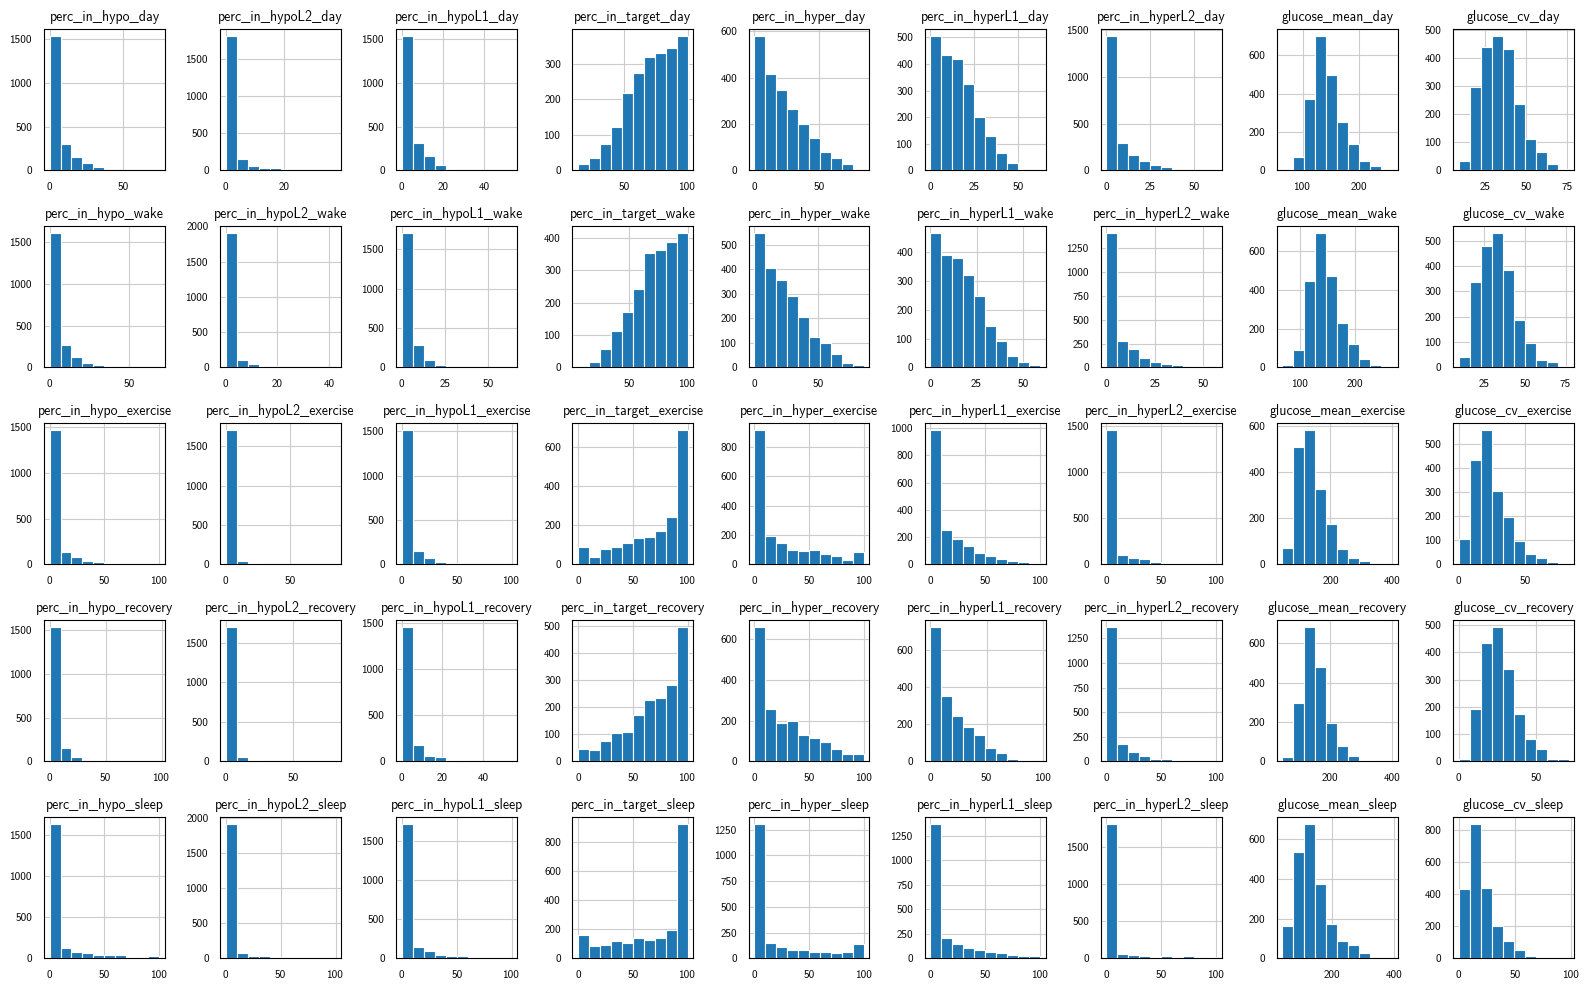

In [60]:
dc_agg.iloc[:, dc_agg.columns.str.startswith('perc_in_') | 
               dc_agg.columns.str.startswith('glucose_mean_') | 
               dc_agg.columns.str.startswith('glucose_cv_')].hist(figsize=(16,10), layout=(5,9))
plt.show()

#### CGM statistics per participant

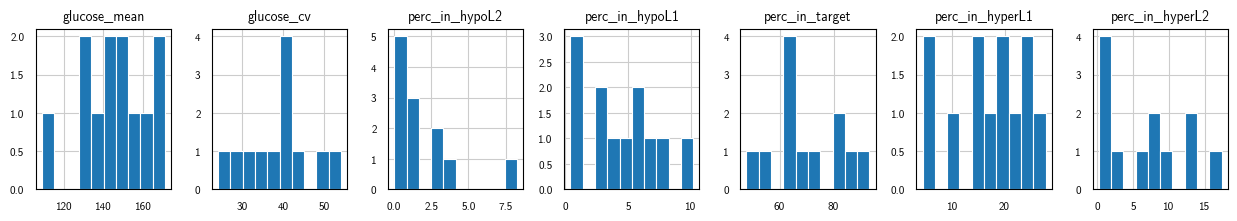

In [61]:
dc_rider = get_cgm_stats(dc)
dc_rider['day'].hist(figsize=(16,10), layout=(5,9))
plt.show()

### Shapiro-Wilk test for normality

Null hypothesis: population is normally distributed

In [62]:
from scipy.stats import shapiro

In [63]:
for d, data in days.items():
    print(tnames[d])
    dc_rider = get_cgm_stats(data, combine='all')
    tstats = {}
    for sec in stat_cols:
        res = {}
        for name in dc_rider.columns.get_level_values(1).unique():
            t, p = shapiro(dc_rider[sec][name])
            res[name] = [t, p]
        res = pd.DataFrame(res, index=['W', 'p']).T
        res['sign'] = res['p'].apply(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else '')))
        res = res.round({'W':2, 'p':3})
        tstats[sec] = res
    tstats = pd.concat(tstats, axis=1)
    display(tstats)
    tstats.to_csv(f'{SAVE_PATH}shapiro_{d}.csv')    
    with open(f'{SAVE_PATH}shapiro_{d}.tex', 'w') as file:
        file.write(tstats.to_latex(column_format='lrrlrrlrrlrrlrrl', escape=False))

All days (d=2115)


day              wake             exercise              \
                    W      p sign     W      p sign        W      p sign   
glucose_mean     0.97  0.871       0.97  0.902          0.96  0.712        
glucose_cv       0.97  0.905       0.96  0.848          0.94  0.499        
perc_in_hypo     0.93  0.413       0.89  0.130          0.79  0.007   **   
perc_in_hypoL2   0.77  0.004   **  0.69  0.001  ***     0.51  0.000  ***   
perc_in_hypoL1   0.97  0.882       0.95  0.584          0.91  0.205        
perc_in_target   0.96  0.723       0.94  0.509          0.94  0.526        
perc_in_hyper    0.95  0.583       0.92  0.313          0.92  0.306        
perc_in_hyperL1  0.96  0.805       0.94  0.480          0.89  0.111        
perc_in_hyperL2  0.93  0.363       0.93  0.380          0.91  0.211        

                recovery             sleep              
                       W      p sign     W      p sign  
glucose_mean        0.96  0.780       0.91  0.220       
glucose_cv          0.98  0.980       0.93  0.431       
perc_in_hypo        0.80  0.009   **  0.93  0.429       
perc_in_hypoL2      0.77  0.004   **  0.87  0.073       
perc_in_hypoL1      0.80  0.008   **  0.92  0.290       
perc_in_target      0.92  0.306       0.95  0.641       
perc_in_hyper       0.92  0.308       0.87  0.059       
perc_in_hyperL1     0.92  0.281       0.92  0.271       
perc_in_hyperL2     0.93  0.387       0.79  0.007   **

Training days (d=1536)


day              wake             exercise              \
                    W      p sign     W      p sign        W      p sign   
glucose_mean     0.96  0.792       0.96  0.727          0.95  0.627        
glucose_cv       0.98  0.959       0.97  0.868          0.91  0.233        
perc_in_hypo     0.94  0.467       0.88  0.088          0.79  0.008   **   
perc_in_hypoL2   0.77  0.005   **  0.65  0.000  ***     0.52  0.000  ***   
perc_in_hypoL1   0.96  0.849       0.94  0.534          0.92  0.292        
perc_in_target   0.96  0.830       0.96  0.821          0.97  0.871        
perc_in_hyper    0.94  0.515       0.94  0.542          0.94  0.556        
perc_in_hyperL1  0.96  0.749       0.94  0.468          0.93  0.375        
perc_in_hyperL2  0.93  0.357       0.92  0.286          0.89  0.130        

                recovery             sleep              
                       W      p sign     W      p sign  
glucose_mean        0.95  0.696       0.88  0.095       
glucose_cv          0.98  0.995       0.96  0.750       
perc_in_hypo        0.77  0.005   **  0.94  0.538       
perc_in_hypoL2      0.73  0.002   **  0.91  0.208       
perc_in_hypoL1      0.78  0.005   **  0.89  0.115       
perc_in_target      0.93  0.346       0.96  0.768       
perc_in_hyper       0.91  0.238       0.84  0.029    *  
perc_in_hyperL1     0.90  0.150       0.90  0.143       
perc_in_hyperL2     0.92  0.315       0.77  0.004   **

Competition days (d=256)


day              wake             exercise              \
                    W      p sign     W      p sign        W      p sign   
glucose_mean     0.95  0.628       0.96  0.734          0.93  0.418        
glucose_cv       0.91  0.237       0.91  0.247          0.91  0.268        
perc_in_hypo     0.81  0.013    *  0.89  0.126          0.80  0.009   **   
perc_in_hypoL2   0.64  0.000  ***  0.71  0.001  ***     0.63  0.000  ***   
perc_in_hypoL1   0.89  0.149       0.93  0.418          0.85  0.048    *   
perc_in_target   0.89  0.141       0.86  0.066          0.90  0.169        
perc_in_hyper    0.93  0.446       0.92  0.307          0.90  0.171        
perc_in_hyperL1  0.95  0.608       0.94  0.470          0.92  0.360        
perc_in_hyperL2  0.86  0.062       0.88  0.120          0.94  0.577        

                recovery             sleep              
                       W      p sign     W      p sign  
glucose_mean        0.95  0.617       0.84  0.035    *  
glucose_cv          0.92  0.357       0.97  0.913       
perc_in_hypo        0.87  0.071       0.82  0.016    *  
perc_in_hypoL2      0.66  0.000  ***  0.63  0.000  ***  
perc_in_hypoL1      0.88  0.112       0.82  0.018    *  
perc_in_target      0.91  0.260       0.92  0.281       
perc_in_hyper       0.95  0.584       0.88  0.119       
perc_in_hyperL1     0.98  0.941       0.95  0.639       
perc_in_hyperL2     0.91  0.213       0.77  0.004   **

### One-sample t-test for comparison with clinical targets

Test is performed on a participant level, i.e., there are n=12 samples

In [64]:
from scipy.stats import ttest_1samp

In [65]:
targets = {'perc_in_hypo'   : 4,
           'perc_in_hypoL2' : 1,#(1, 'greater'),
           'perc_in_hypoL1' : 3,#(3, 'greater'),
           'perc_in_target' : 70,#(70, 'less'),
           'perc_in_hyper'  : 25,
           'perc_in_hyperL1': 20,#(20, 'greater'),
           'perc_in_hyperL2': 5,#(5, 'greater'),
           'glucose_cv'     : 36}#(36, 'greater')}

In [66]:
for d, data in days.items():
    print(tnames[d])
    dc_rider = get_cgm_stats(data, combine='all')
    tstats = {}
    for sec in stat_cols:
        res = {}
        #for name, (value, method) in targets.items():
        for name, value in targets.items():
            t, p = ttest_1samp(dc_rider[sec][name], value)#, alternative=method)
            res[name] = [t, p]
        res = pd.DataFrame(res, index=['t', 'p']).T
        res['sign'] = res['p'].apply(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else '')))
        res = res.round({'t':2, 'p':3})
        tstats[sec] = res
    tstats = pd.concat(tstats, axis=1)
    display(tstats)
    tstats.to_csv(f'{SAVE_PATH}ttest_onesamp_{d}.csv')    
    with open(f'{SAVE_PATH}ttest_onesamp_{d}.tex', 'w') as file:
        file.write(tstats.to_latex(column_format='lrrlrrlrrlrrlrrl', escape=False))

All days (d=2115)


day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
perc_in_hypo     1.79  0.101       1.10  0.293          0.82  0.430        
perc_in_hypoL2   1.45  0.176       0.92  0.379          0.47  0.649        
perc_in_hypoL1   1.73  0.112       1.07  0.308          1.03  0.325        
perc_in_target  -0.01  0.992       0.03  0.980          0.09  0.933        
perc_in_hyper   -0.39  0.703      -0.14  0.891         -0.17  0.870        
perc_in_hyperL1 -1.45  0.176      -1.01  0.336         -1.15  0.276        
perc_in_hyperL2  1.07  0.309       1.13  0.284          1.42  0.183        
glucose_cv       1.20  0.256       0.84  0.421          1.29  0.225        

                recovery             sleep              
                       t      p sign     t      p sign  
perc_in_hypo        0.28  0.788       2.72  0.020    *  
perc_in_hypoL2      0.29  0.775       2.39  0.036    *  
perc_in_hypoL1      0.26  0.797       2.50  0.030    *  
perc_in_target     -0.50  0.630      -0.09  0.929       
perc_in_hyper       0.61  0.557      -0.93  0.375       
perc_in_hyperL1    -0.09  0.928      -2.39  0.036    *  
perc_in_hyperL2     1.49  0.165       0.70  0.495       
glucose_cv          0.25  0.811       1.55  0.150

Training days (d=1536)


day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
perc_in_hypo     2.01  0.069       1.32  0.215          1.14  0.277        
perc_in_hypoL2   1.54  0.152       0.98  0.346          0.66  0.524        
perc_in_hypoL1   1.99  0.072       1.37  0.197          1.44  0.177        
perc_in_target   0.24  0.813       0.35  0.734          0.44  0.667        
perc_in_hyper   -0.81  0.433      -0.63  0.542         -0.77  0.458        
perc_in_hyperL1 -1.82  0.096      -1.47  0.170         -1.73  0.112        
perc_in_hyperL2  0.74  0.474       0.75  0.466          0.97  0.355        
glucose_cv       1.16  0.270       0.82  0.430          1.23  0.245        

                recovery             sleep              
                       t      p sign     t      p sign  
perc_in_hypo        0.34  0.743       2.85  0.016    *  
perc_in_hypoL2      0.30  0.768       2.70  0.021    *  
perc_in_hypoL1      0.35  0.735       2.56  0.027    *  
perc_in_target     -0.33  0.746      -0.04  0.966       
perc_in_hyper       0.43  0.677      -1.04  0.319       
perc_in_hyperL1    -0.18  0.864      -2.25  0.046    *  
perc_in_hyperL2     1.29  0.223       0.57  0.577       
glucose_cv          0.06  0.953       1.42  0.183

Competition days (d=256)


day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
perc_in_hypo     0.53  0.609      -0.40  0.701         -6.76  0.000  ***   
perc_in_hypoL2   0.76  0.466       0.18  0.861         -6.16  0.000  ***   
perc_in_hypoL1   0.25  0.810      -0.78  0.454         -6.68  0.000  ***   
perc_in_target   0.02  0.986      -0.18  0.860         -2.44  0.035    *   
perc_in_hyper    0.05  0.958       0.59  0.566          3.47  0.006   **   
perc_in_hyperL1 -0.86  0.409       0.04  0.969          2.79  0.019    *   
perc_in_hyperL2  1.14  0.281       1.13  0.283          2.99  0.013    *   
glucose_cv       0.42  0.684      -0.03  0.979         -1.01  0.336        

                recovery             sleep              
                       t      p sign     t      p sign  
perc_in_hypo       -0.64  0.538       1.33  0.212       
perc_in_hypoL2     -0.59  0.570       1.21  0.255       
perc_in_hypoL1     -0.61  0.559       1.19  0.260       
perc_in_target     -0.72  0.488       0.33  0.750       
perc_in_hyper       1.08  0.306      -0.87  0.406       
perc_in_hyperL1     0.14  0.892      -2.62  0.026    *  
perc_in_hyperL2     1.62  0.136       0.81  0.436       
glucose_cv         -0.07  0.949       0.19  0.856

### One-sample Wilcoxon signed-rank test for comparison with clinical targets

Test is performed on a participant level, i.e., there are n=12 samples

In [67]:
from scipy.stats import wilcoxon

In [68]:
for d, data in days.items():
    print(tnames[d])
    dc_rider = get_cgm_stats(data, combine='all')
    tstats = {}
    for sec in stat_cols:
        res = {}
        for name, value in targets.items():
            t, p = wilcoxon(dc_rider[sec][name] - value)
            res[name] = [t, p]
        res = pd.DataFrame(res, index=['t', 'p']).T
        res['sign'] = res['p'].apply(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else '')))
        res = res.round({'t':2, 'p':3})
        tstats[sec] = res
    tstats = pd.concat(tstats, axis=1)
    display(tstats)
    tstats.to_csv(f'{SAVE_PATH}wilcoxon_onesamp_{d}.csv')    
    with open(f'{SAVE_PATH}wilcoxon_onesamp_{d}.tex', 'w') as file:
        file.write(tstats.to_latex(column_format='lrrlrrlrrlrrlrrl', escape=False))

All days (d=2115)


day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
perc_in_hypo     21.0  0.176       31.0  0.569          35.0  0.791        
perc_in_hypoL2   27.0  0.380       34.0  0.733          23.0  0.233        
perc_in_hypoL1   20.0  0.151       28.0  0.424          30.0  0.519        
perc_in_target   38.0  0.970       39.0  1.000          37.0  0.910        
perc_in_hyper    35.0  0.791       39.0  1.000          34.0  0.733        
perc_in_hyperL1  24.0  0.266       30.0  0.519          27.0  0.380        
perc_in_hyperL2  31.0  0.569       26.0  0.339          22.0  0.204        
glucose_cv       26.0  0.339       30.0  0.519          27.0  0.380        

                recovery             sleep              
                       t      p sign     t      p sign  
perc_in_hypo        35.0  0.791       13.0  0.042    *  
perc_in_hypoL2      34.0  0.733       14.0  0.052       
perc_in_hypoL1      33.0  0.677       14.0  0.052       
perc_in_target      30.0  0.519       38.0  0.970       
perc_in_hyper       28.0  0.424       22.0  0.204       
perc_in_hyperL1     34.0  0.733       12.0  0.034    *  
perc_in_hyperL2     23.0  0.233       38.0  0.970       
glucose_cv          39.0  1.000       19.0  0.129

Training days (d=1536)


day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
perc_in_hypo     19.0  0.129       27.0  0.380          30.0  0.519        
perc_in_hypoL2   24.0  0.266       37.0  0.910          29.0  0.470        
perc_in_hypoL1   16.0  0.077       25.0  0.301          26.0  0.339        
perc_in_target   38.0  0.970       38.0  0.970          34.0  0.733        
perc_in_hyper    29.0  0.470       34.0  0.733          29.0  0.470        
perc_in_hyperL1  20.0  0.151       24.0  0.266          19.0  0.129        
perc_in_hyperL2  32.0  0.622       33.0  0.677          30.0  0.519        
glucose_cv       26.0  0.339       30.0  0.519          25.0  0.301        

                recovery             sleep              
                       t      p sign     t      p sign  
perc_in_hypo        33.0  0.677       13.0  0.042    *  
perc_in_hypoL2      32.0  0.622       11.0  0.027    *  
perc_in_hypoL1      33.0  0.677       15.0  0.064       
perc_in_target      30.0  0.519       38.0  0.970       
perc_in_hyper       28.0  0.424       22.0  0.204       
perc_in_hyperL1     32.0  0.622       14.0  0.052       
perc_in_hyperL2     25.0  0.301       34.0  0.733       
glucose_cv          37.0  0.910       22.0  0.204

Competition days (d=256)


day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
perc_in_hypo     31.0  0.898       27.0  0.638           0.0  0.001  ***   
perc_in_hypoL2   30.0  0.831       30.0  0.831           1.0  0.002   **   
perc_in_hypoL1   30.0  0.831       25.0  0.520           1.0  0.002   **   
perc_in_target   32.0  0.966       32.0  0.966           6.0  0.014    *   
perc_in_hyper    32.0  0.966       26.0  0.577           6.0  0.014    *   
perc_in_hyperL1  25.0  0.520       33.0  1.000           9.0  0.032    *   
perc_in_hyperL2  20.0  0.278       21.0  0.320           9.0  0.032    *   
glucose_cv       30.0  0.831       31.0  0.898          23.0  0.413        

                recovery             sleep              
                       t      p sign     t      p sign  
perc_in_hypo        22.0  0.365       25.0  0.520       
perc_in_hypoL2      17.0  0.175       32.0  0.966       
perc_in_hypoL1      26.0  0.577       29.0  0.765       
perc_in_target      25.0  0.520       30.0  0.831       
perc_in_hyper       20.0  0.278       21.0  0.320       
perc_in_hyperL1     28.0  0.700        9.0  0.032    *  
perc_in_hyperL2     18.0  0.206       28.0  0.700       
glucose_cv          31.0  0.898       33.0  1.000

### Dependent t-test for comparison of training and competition days

Test is performed on a participant level, i.e., there are n=12-1 samples

In [69]:
from scipy.stats import ttest_rel

In [70]:
dc_comp = get_cgm_stats(dc[dc['race_day'] & dc['exercise_day']], combine='all')
dc_train = get_cgm_stats(dc[~dc['race_day'] & dc['exercise_day']], combine='all')
dc_train = dc_train.drop(9) # participant 9 did not have any races

In [71]:
tstats = {}
for sec in stat_cols:
    res = {}
    for name in dc_comp.columns.get_level_values(1).unique():
        t, p = ttest_rel(dc_train[sec][name], dc_comp[sec][name])
        res[name] = [t, p]
    res = pd.DataFrame(res, index=['t', 'p']).T
    res['sign'] = res['p'].apply(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else '')))
    res = res.round({'t':2, 'p':3})
    tstats[sec] = res
tstats = pd.concat(tstats, axis=1)
display(tstats)
tstats.to_csv(f'{SAVE_PATH}ttest_rel.csv')    
with open(f'{SAVE_PATH}ttest_rel.tex', 'w') as file:
    file.write(tstats.to_latex(column_format='lrrlrrlrrlrrlrrl', escape=False))

day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
glucose_mean    -2.73  0.021    * -3.51  0.006   **    -6.55  0.000  ***   
glucose_cv       1.64  0.133       2.03  0.069          3.57  0.005   **   
perc_in_hypo     2.00  0.073       2.09  0.063          2.85  0.017    *   
perc_in_hypoL2   2.22  0.050       1.66  0.128          1.51  0.163        
perc_in_hypoL1   1.87  0.091       2.02  0.071          3.64  0.005   **   
perc_in_target   1.21  0.256       1.91  0.085          3.30  0.008   **   
perc_in_hyper   -3.08  0.012    * -3.84  0.003   **    -5.49  0.000  ***   
perc_in_hyperL1 -3.05  0.012    * -4.04  0.002   **    -5.53  0.000  ***   
perc_in_hyperL2 -1.44  0.182      -1.47  0.173         -3.26  0.009   **   

                recovery             sleep              
                       t      p sign     t      p sign  
glucose_mean       -2.34  0.041    * -0.44  0.672       
glucose_cv          0.44  0.667       1.06  0.314       
perc_in_hypo        0.87  0.407       0.83  0.426       
perc_in_hypoL2      0.78  0.455       0.40  0.696       
perc_in_hypoL1      0.87  0.403       1.01  0.335       
perc_in_target      1.24  0.242      -0.80  0.441       
perc_in_hyper      -1.66  0.127       0.04  0.966       
perc_in_hyperL1    -1.09  0.300       0.66  0.521       
perc_in_hyperL2    -1.40  0.193      -0.51  0.619

In [72]:
dc_diff = dc_comp['exercise'] - dc_train['exercise']
dc_diff = dc_diff.apply(lambda x: [x.median(), x.quantile(0.25), x.quantile(0.75)]).T
dc_diff = dc_diff.rename(columns={0:'median', 1:'p25', 2:'p75'})
dc_diff = dc_diff.round(1)
dc_diff

,median,p25,p75
glucose_mean,34.1,25.2,41.9
glucose_cv,-4.2,-7.8,-3.4
perc_in_hypo,-2.6,-6.9,-2.1
perc_in_hypoL2,-0.3,-1.2,-0.1
perc_in_hypoL1,-2.2,-5.6,-2.0
perc_in_target,-14.0,-17.4,-5.1
perc_in_hyper,16.4,12.9,24.0
perc_in_hyperL1,10.4,7.7,15.7
perc_in_hyperL2,6.0,0.5,9.2


In [73]:
diff_glucose_mean = (dc_comp['exercise']['glucose_mean'] - dc_train['exercise']['glucose_mean'])/dc_train['exercise']['glucose_mean'] * 100
print("Difference in mean glucose of {:.1f} [{:.1f}-{:.1f}]%"\
      .format(diff_glucose_mean.median(), diff_glucose_mean.quantile(0.25), diff_glucose_mean.quantile(0.75)))

Difference in mean glucose of 24.4 [17.7-32.8]%


In [74]:
dc_diff = dc_comp['recovery'] - dc_train['recovery']
dc_diff = dc_diff.apply(lambda x: [x.median(), x.quantile(0.25), x.quantile(0.75)]).T
dc_diff = dc_diff.rename(columns={0:'median', 1:'p25', 2:'p75'})
dc_diff = dc_diff.round(1)
dc_diff

,median,p25,p75
glucose_mean,9.6,-1.7,23.5
glucose_cv,-1.0,-2.9,1.9
perc_in_hypo,-0.3,-2.8,0.9
perc_in_hypoL2,-0.2,-0.9,0.1
perc_in_hypoL1,-0.4,-1.8,0.6
perc_in_target,-1.4,-5.9,1.0
perc_in_hyper,2.5,-1.6,9.9
perc_in_hyperL1,0.9,-3.1,5.5
perc_in_hyperL2,1.2,-1.1,3.6


### Paired Wilcoxon signed-rank test for comparison of training and competition days

Test is performed on a participant level, i.e., there are n=12-1 samples

In [75]:
from scipy.stats import wilcoxon

In [76]:
dc_comp = get_cgm_stats(dc[dc['race_day'] & dc['exercise_day']], combine='all')
dc_train = get_cgm_stats(dc[~dc['race_day'] & dc['exercise_day']], combine='all')
dc_train = dc_train.drop(9) # participant 9 did not have any races

In [77]:
tstats = {}
for sec in stat_cols:
    res = {}
    for name in dc_comp.columns.get_level_values(1).unique():
        t, p = wilcoxon(dc_train[sec][name], dc_comp[sec][name])
        res[name] = [t, p]
    res = pd.DataFrame(res, index=['t', 'p']).T
    res['sign'] = res['p'].apply(lambda p: '***' if p < 0.001 else ('**' if p < 0.01 else ('*' if p < 0.05 else '')))
    res = res.round({'t':2, 'p':3})
    tstats[sec] = res
tstats = pd.concat(tstats, axis=1)
display(tstats)
tstats.to_csv(f'{SAVE_PATH}wilcoxon_rel.csv')    
with open(f'{SAVE_PATH}wilcoxon_rel.tex', 'w') as file:
    file.write(tstats.to_latex(column_format='lrrlrrlrrlrrlrrl', escape=False))

/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/local/home/evanweenen/.local/lib/python3.7/site-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


day              wake             exercise              \
                    t      p sign     t      p sign        t      p sign   
glucose_mean      8.0  0.024    *   2.0  0.003   **      1.0  0.002   **   
glucose_cv       16.0  0.147       15.0  0.123           2.0  0.003   **   
perc_in_hypo      7.0  0.019    *  16.0  0.147           2.0  0.003   **   
perc_in_hypoL2   13.0  0.083       20.0  0.278           6.0  0.051        
perc_in_hypoL1   12.0  0.067       13.0  0.083           2.0  0.003   **   
perc_in_target   18.0  0.206       14.0  0.102           7.0  0.019    *   
perc_in_hyper     7.0  0.019    *   2.0  0.003   **      1.0  0.002   **   
perc_in_hyperL1   7.0  0.019    *   1.0  0.002   **      1.0  0.002   **   
perc_in_hyperL2  18.0  0.206       22.0  0.365           4.0  0.007   **   

                recovery             sleep              
                       t      p sign     t      p sign  
glucose_mean        11.0  0.054       29.0  0.765       
glucose_cv          27.0  0.638       21.0  0.320       
perc_in_hypo        24.0  0.465       20.0  0.278       
perc_in_hypoL2      18.0  0.333       18.0  0.206       
perc_in_hypoL1      24.0  0.465       22.0  0.365       
perc_in_target      21.0  0.320       24.0  0.465       
perc_in_hyper       18.0  0.206       32.0  0.966       
perc_in_hyperL1     24.0  0.465       25.0  0.520       
perc_in_hyperL2     21.0  0.320       21.0  0.859

### Multi-level logistic regression to compare mean glucose on training and competition days

Logistic regression (as a form of hierarchical unequal-sampled t-test)

In [78]:
from pymer4.models import Lmer

/local/home/evanweenen/.local/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [79]:
df_stats = dc_agg.copy()
df_stats = df_stats[['RIDER', 'glucose_mean_day', 'glucose_mean_wake', 'glucose_mean_exercise', 
                     'glucose_mean_recovery', 'glucose_mean_sleep', 'race_day', 'exercise_day']]

In [80]:
model = Lmer('glucose_mean_exercise ~ 1+race_day + (1+race_day | RIDER)', 
             data=df_stats[df_stats['exercise_day']].dropna(subset=['glucose_mean_exercise']))
print(model.fit())

Formula: glucose_mean_exercise~1+race_day+(1+race_day|RIDER)

Family: gaussian	 Inference: parametric

Number of observations: 1788	 Groups: {'RIDER': 12.0}

Log-likelihood: -9315.565 	 AIC: 18631.131

Random effects:

                  Name       Var     Std
RIDER      (Intercept)   360.882  18.997
RIDER     race_dayTRUE   154.511  12.430
Residual                1927.081  43.899

               IV1           IV2   Corr
RIDER  (Intercept)  race_dayTRUE -0.638

Fixed effects:

              Estimate   2.5_ci  97.5_ci     SE      DF  T-stat  P-val  Sig
(Intercept)    140.653  129.613  151.694  5.633  10.931  24.969    0.0  ***
race_dayTRUE    35.115   25.442   44.787  4.935   8.370   7.116    0.0  ***


In [81]:
model.coefs

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),140.653411,129.612866,151.693956,5.633035,10.930516,24.969385,5.453630e-11,***
race_dayTRUE,35.114555,25.442477,44.786632,4.934824,8.369809,7.115665,8.029734e-05,***


In [82]:
model.coefs[['Estimate', '2.5_ci', '97.5_ci']].style.format('{:.1f}')

,Estimate,2.5_ci,97.5_ci
(Intercept),140.7,129.6,151.7
race_dayTRUE,35.1,25.4,44.8


In [83]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', ['Estimate', '2.5_ci', '97.5_ci']]

Estimate    0.249653
2.5_ci      0.196296
97.5_ci     0.295243
dtype: object

In [84]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', 'Estimate']

Estimate    0.249653
2.5_ci      0.180888
97.5_ci     0.318418
Name: race_dayTRUE, dtype: object

In [85]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', '2.5_ci']

Estimate    0.270919
2.5_ci      0.196296
97.5_ci     0.345542
Name: race_dayTRUE, dtype: object

In [86]:
model.coefs.loc['race_dayTRUE', ['Estimate', '2.5_ci', '97.5_ci']] / model.coefs.loc['(Intercept)', '97.5_ci']

Estimate    0.231483
2.5_ci      0.167722
97.5_ci     0.295243
Name: race_dayTRUE, dtype: object

In [87]:
print("Increase of 25.0 [16.8-34.6]%")

Increase of 25.0 [16.8-34.6]%


### Some additional checks

In [88]:
tp_agg.groupby('RIDER')[[('TIME', 'timestamp_count')]].agg([lambda x: (x/3600).mean(), lambda x: (x/3600).std()])

TIME           
      timestamp_count           
           <lambda_0> <lambda_1>
RIDER                           
1            2.923549   1.421886
2            2.931333   1.242411
3            3.148100   1.383935
4            3.718611   1.401517
5            3.242701   1.437479
6            3.056150   1.423807
7            3.278969   1.473573
8            3.055672   1.410199
9            2.806168   1.231778
10           3.171985   1.586737
11           3.389436   1.443645
12           3.076420   1.478510

## Unused analyses

### Competition vs. training

Sign test

In [210]:
from statsmodels.stats.descriptivestats import sign_test

In [211]:
def get_signtest_per_sec(dc, mask):
    targets = {'time_in_hypoL2' : 1,
               'time_in_hypoL1' : 3,
               'time_in_target' : 70,
               'time_in_hyperL1': 20,
               'time_in_hyperL2': 5,
               'glucose_cv'     : 36}
    
    stats = get_complete_stats(dc[mask])

    return pd.DataFrame({k: sign_test(stats[k], v) for k, v in targets.items()}).T

In [212]:
def get_signtest(dc):
    res = pd.concat({**{'all': get_signtest_per_sec(dc, [True]*len(dc))}, 
              **{sec  : get_signtest_per_sec(dc, dc[sec]) for sec in SECTIONS}})
    res['sign.'] = res[1].apply(lambda x: '***' if x < 0.001 else ('**' if x < 0.01 else ('*' if x < 0.05 else '')))
    res = res.unstack(level=0)
    res.columns = res.columns.swaplevel(0,1)
    res = res.sort_index(axis=1, key=lambda x: x.map({**{'all':0}, **{s: i+1 for i, s in enumerate(SECTIONS)}}))
    res = res.rename(columns={0:'M', 1:'p'})
    return res

In [213]:
from IPython.display import display
for d, df in days.items():
    display(d, get_signtest(df))

'all'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2   1.0  0.774414       -1.0  0.774414           -3.0  0.145996   
time_in_hypoL1   2.0  0.387695        2.0  0.387695            1.0  0.774414   
time_in_target  -1.0  0.774414       -1.0  0.774414            1.0  0.774414   
time_in_hyperL1 -1.0  0.774414       -1.0  0.774414           -2.0  0.387695   
time_in_hyperL2  1.0  0.774414        1.0  0.774414            2.0  0.387695   
glucose_cv       2.0  0.387695        2.0  0.387695            1.0  0.774414   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2            -2.0  0.387695         2.0  0.387695        
time_in_hypoL1            -2.0  0.387695         2.0  0.387695        
time_in_target            -3.0  0.145996         1.0  0.774414        
time_in_hyperL1            2.0  0.387695        -4.0  0.038574     *  
time_in_hyperL2            1.0  0.774414        -1.0  0.774414        
glucose_cv                -1.0  0.774414         3.0  0.145996

'race'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2  -2.5  0.226562       -2.5  0.226562           -4.5  0.011719   
time_in_hypoL1  -0.5  1.000000       -1.5  0.548828           -4.5  0.011719   
time_in_target  -0.5  1.000000       -0.5  1.000000           -2.5  0.226562   
time_in_hyperL1 -1.5  0.548828       -1.5  0.548828            2.5  0.226562   
time_in_hyperL2  0.5  1.000000        0.5  1.000000            3.5  0.065430   
glucose_cv       1.5  0.548828        0.5  1.000000           -2.5  0.226562   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2      *     -2.5  0.226562        -0.5  1.000000        
time_in_hypoL1      *     -1.5  0.548828        -0.5  1.000000        
time_in_target            -2.5  0.226562         0.5  1.000000        
time_in_hyperL1            0.5  1.000000        -3.5  0.065430        
time_in_hyperL2            0.5  1.000000        -1.5  0.548828        
glucose_cv                -0.5  1.000000        -0.5  1.000000

'train'

all                 wake                 exercise            \
                   M         p sign.    M         p sign.        M         p   
time_in_hypoL2   1.0  0.774414       -1.0  0.774414           -3.0  0.145996   
time_in_hypoL1   2.0  0.387695        2.0  0.387695            1.0  0.774414   
time_in_target  -1.0  0.774414       -1.0  0.774414            1.0  0.774414   
time_in_hyperL1 -1.0  0.774414       -2.0  0.387695           -2.0  0.387695   
time_in_hyperL2  1.0  0.774414        1.0  0.774414            2.0  0.387695   
glucose_cv       2.0  0.387695        2.0  0.387695            1.0  0.774414   

                      recovery                 sleep                  
                sign.        M         p sign.     M         p sign.  
time_in_hypoL2            -2.0  0.387695         2.0  0.387695        
time_in_hypoL1            -2.0  0.387695         2.0  0.387695        
time_in_target            -2.0  0.387695         0.0  1.000000        
time_in_hyperL1            2.0  0.387695        -4.0  0.038574     *  
time_in_hyperL2            2.0  0.387695        -1.0  0.774414        
glucose_cv                -1.0  0.774414         2.0  0.387695